In [70]:
import os
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import matplotlib.pyplot as plt
import numpy as np


In [71]:
# Parameters
image_size = (256, 256)  # Resize all images to this size
batch_size = 32
seed = 123

image_directory = r"C:\Users\pasir\Desktop\PR_assignment\realwaste\realwaste-main\RealWaste"

# Load the dataset
full_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    image_directory,
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True,
    seed=seed
)


Found 4752 files belonging to 9 classes.


Classes: ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']
Image batch shape: (32, 256, 256, 3)
Label batch shape: (32,)


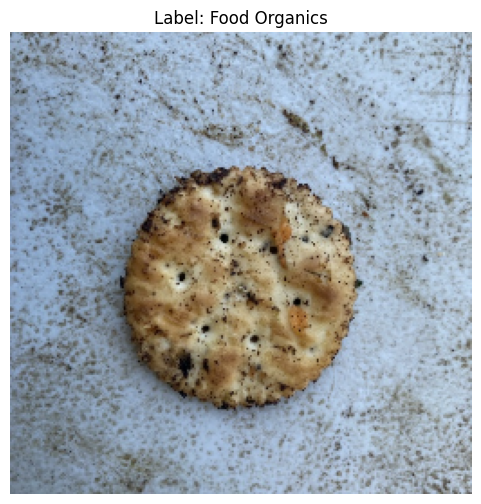

In [72]:
# Display class names
class_names = full_dataset.class_names
print("Classes:", class_names)

# Inspect a batch of images and labels
for images, labels in full_dataset.take(1):
    print(f"Image batch shape: {images.shape}")
    print(f"Label batch shape: {labels.shape}")
    image = images[0].numpy().astype("uint8")  
    label = labels[0].numpy()
# Plot the image
plt.figure(figsize=(6, 6))
plt.imshow(image)  
plt.title(f"Label: {class_names[label]}")  
plt.axis("off")  
plt.show()

In [73]:
# Get the total number of samples
num_samples = len(full_dataset.file_paths)


# Calculate the split sizes
train_size = int(0.6 * num_samples/32)
val_size = int(0.2 * num_samples/32)
test_size = int(num_samples/32 - train_size - val_size)  # Ensure all data is used



# Split the dataset
train_dataset = full_dataset.take(train_size)
remainder_dataset = full_dataset.skip(train_size)

val_dataset = remainder_dataset.take(val_size)
test_dataset = remainder_dataset.skip(val_size)

# Normalize pixel values to [0, 1]
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

# Optimize data loading
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

# Print dataset sizes
print(f"Total samples: {num_samples}")
print(f"Training samples: {train_size}")
print(f"Validation samples: {val_size}")
print(f"Test samples: {test_size}")

Total samples: 4752
Training samples: 89
Validation samples: 29
Test samples: 30


In [74]:

# Define the CNN model
model = keras.Sequential([
    # First Convolutional Layer with 32 filters and a 3x3 kernel

    
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    layers.BatchNormalization(),
    # MaxPooling layer to downsample the feature maps
    layers.MaxPooling2D((2, 2)),

    # Second Convolutional Layer with 64 filters and a 3x3 kernel
    layers.Conv2D(64, (3, 3), activation='relu'),
 
    # MaxPooling layer to downsample the feature maps
    layers.MaxPooling2D((2, 2)),
    
    # Second Convolutional Layer with 64 filters and a 3x3 kernel
    layers.Conv2D(128, (3, 3), activation='relu'),

    # MaxPooling layer to downsample the feature maps
    layers.MaxPooling2D((2, 2)),
    # Flatten the 2D feature maps to a 1D array
    layers.Flatten(),
    
    layers.Dropout(0.5),

    # Add a dense (fully connected) layer with 128 units and ReLU activation
    layers.Dense(128, activation='relu'),

    # Add another dense layer with 64 units and ReLU activation
    layers.Dense(64, activation='relu'),

    # Add the output layer with 10 units (one for each class) and softmax activation
    layers.Dense(9, activation='softmax')
])
model.summary()

learning_rate = 0.0001

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])



Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 batch_normalization_7 (Batc  (None, 254, 254, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                            
                                                      

In [75]:
# Train the model and collect training history
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20
)


Epoch 1/20
89/89 [==============================] - 10s 106ms/step - loss: 1.6842 - accuracy: 0.4080 - val_loss: 2.1145 - val_accuracy: 0.2554
Epoch 2/20
89/89 [==============================] - 9s 94ms/step - loss: 1.1273 - accuracy: 0.6106 - val_loss: 1.9496 - val_accuracy: 0.3297
Epoch 3/20
89/89 [==============================] - 9s 95ms/step - loss: 0.8423 - accuracy: 0.7114 - val_loss: 1.6533 - val_accuracy: 0.4860
Epoch 4/20
89/89 [==============================] - 9s 96ms/step - loss: 0.6368 - accuracy: 0.7914 - val_loss: 1.4414 - val_accuracy: 0.5312
Epoch 5/20
89/89 [==============================] - 9s 96ms/step - loss: 0.4781 - accuracy: 0.8459 - val_loss: 1.1118 - val_accuracy: 0.6487
Epoch 6/20
89/89 [==============================] - 9s 96ms/step - loss: 0.3432 - accuracy: 0.9048 - val_loss: 1.1253 - val_accuracy: 0.5948
Epoch 7/20
89/89 [==============================] - 9s 96ms/step - loss: 0.2703 - accuracy: 0.9182 - val_loss: 1.0274 - val_accuracy: 0.6509
Epoch 8/20


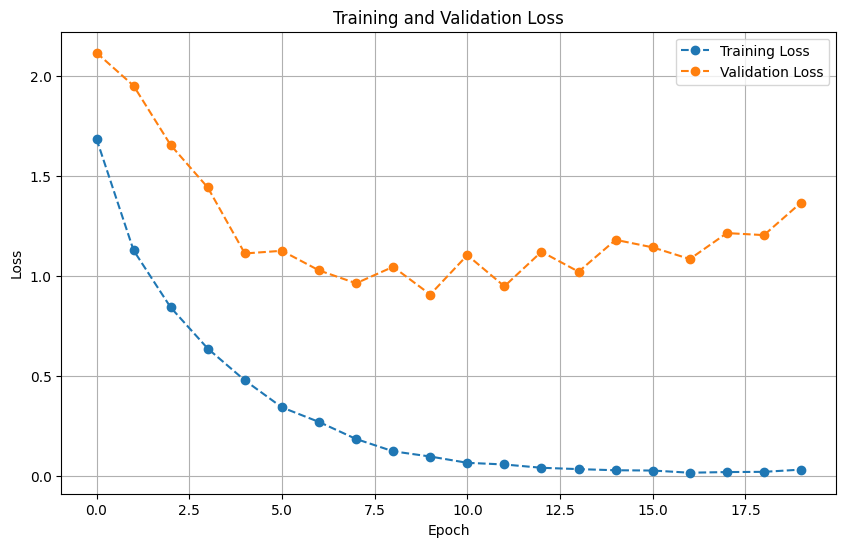

In [76]:
# Plot training, validation, and testing loss with respect to epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', linestyle='--', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [77]:
# Evaluate the model on the test data and collect test loss
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

31/31 [==============================] - 3s 27ms/step - loss: 1.6539 - accuracy: 0.6516
Test Loss: 1.6539270877838135
Test Accuracy: 0.6516393423080444


In [78]:
def predict_single_image(model, image_path, target_size, class_indices):
    # Load and preprocess the image
    img = load_img(image_path, target_size=target_size)  
    img_array = img_to_array(img) / 255.0               
    img_array = np.expand_dims(img_array, axis=0)       

    # Predict
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]  
    class_label = class_names[predicted_class]  
    
    # Plot the image
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicted Label: {class_label}", fontsize=12, color="blue")
    plt.show()

    return class_label, predictions


1/1 [==============================] - 0s 116ms/step


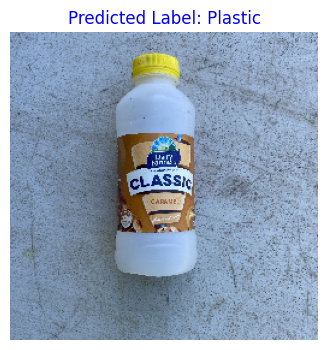

Predicted Label: Plastic


In [79]:
image_path = r"C:\Users\pasir\Desktop\PR_assignment\realwaste\realwaste-main\RealWaste\Plastic\Plastic_28.jpg"

predicted_label, probabilities = predict_single_image(model, image_path, target_size=image_size, class_indices=class_names)

print(f"Predicted Label: {predicted_label}")
